## Mounting the drive in colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install efficientnet_pytorch

## Importing Dataset

In [3]:
from os import getcwd,listdir
from os.path import join
curr_dir = getcwd()
dataset_dir = join(curr_dir,'drive','MyDrive','HolidaySeason1','dataset')
train_img_dir_path = join(dataset_dir,'train')
train_df_path = join(dataset_dir,'train.csv')
test_img_dir_path = join(dataset_dir,'test')
test_df_path = join(dataset_dir,'test.csv')

## Importing Necessary Packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import cv2
import os
import PIL.Image as Image
from pylab import rcParams
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader,Dataset,SubsetRandomSampler
from torchvision import models
from collections import defaultdict

## configuring our setup

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='darkgrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 12

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


In [6]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


### Dataset Inspection

In [7]:
print(f" No. of training images : {len(listdir(train_img_dir_path))}")
print(f" No. of test images: {len(listdir(test_img_dir_path))}")

 No. of training images : 6469
 No. of test images: 3489


In [8]:
train_df = pd.read_csv(train_df_path)
train_df.sample(10)

,Image,Class
2094,image6864.jpg,Miscellaneous
3658,image4610.jpg,Miscellaneous
4852,image2234.jpg,Snowman
351,image3.jpg,Miscellaneous
2166,image3043.jpg,Miscellaneous
3355,image3136.jpg,Miscellaneous
6191,image4671.jpg,Miscellaneous
3252,image4224.jpg,Snowman
6414,image551.jpg,Miscellaneous
2842,image9630.jpg,Jacket


In [9]:
test_df = pd.read_csv(test_df_path)
test_df

,Image
0,image6090.jpg
1,image5081.jpg
2,image9798.jpg
3,image2649.jpg
4,image995.jpg
...,...
3484,image5771.jpg
3485,image7954.jpg
3486,image3154.jpg
3487,image6014.jpg


## Conversion of Labels

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['Class'] = le.fit_transform(train_df['Class'])

In [11]:
train_df

,Image,Class
0,image3476.jpg,4
1,image5198.jpg,1
2,image4183.jpg,5
3,image1806.jpg,4
4,image7831.jpg,4
...,...,...
6464,image2096.jpg,2
6465,image1474.jpg,4
6466,image4124.jpg,0
6467,image7695.jpg,1


In [12]:
train_df['Class'].value_counts()

4    2801
2    1539
3     640
1     593
0     535
5     361
Name: Class, dtype: int64

In [13]:
class_names = le.inverse_transform(range(0,6))
class_names

array(['Airplane', 'Candle', 'Christmas_Tree', 'Jacket', 'Miscellaneous',
       'Snowman'], dtype=object)

In [14]:
train_df.to_csv(join(dataset_dir,'final_train.csv'),index = False)

In [15]:
final_train = pd.read_csv(join(dataset_dir,'final_train.csv'))
final_train

,Image,Class
0,image3476.jpg,4
1,image5198.jpg,1
2,image4183.jpg,5
3,image1806.jpg,4
4,image7831.jpg,4
...,...,...
6464,image2096.jpg,2
6465,image1474.jpg,4
6466,image4124.jpg,0
6467,image7695.jpg,1


In [16]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir_path, transform=None,flg = True):
        ## flag for training or test (default true for training set)
        self.flg = flg
        ## reading the dataframe
        self.dataframe = pd.read_csv(csv_file)
        ## getting the root_dir_path
        self.root_dir_path = root_dir_path
        ## getting imageids from the dataframe
        self.imagenames = self.dataframe["Image"]
        ## getting labels from the dataset if the dataset is training type
        if self.flg:
          self.labels = self.dataframe["Class"]
        ## getting possible transformations of the images
        self.transform = transform


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        ## get the imagename from the dataframe
        imagename = self.imagenames[index]
        ## get the path of the image        
        img_path = os.path.join(self.root_dir_path,imagename)
        ## open the image using PIL.Image and convert it to RGB in case of an extra alpha channel
        image = Image.open(img_path).convert('RGB')
        ## applying transformations to image
        if self.transform:
          image = self.transform(image)
        ## return y label if dataset type is training
        if self.flg:
          y_label = torch.tensor(int(self.labels[index]))
          return (imagename,image,y_label)

        return (imagename,image)  

## Data Transforms

In [17]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]
img_size = 224

In [18]:
train_transforms = T.Compose([
                            T.RandomResizedCrop(size=img_size),
                            T.ToTensor(),
                            T.Normalize(mean_nums, std_nums)
                  ])

test_transforms =  T.Compose([
                            T.RandomResizedCrop(size=img_size),
                            T.ToTensor(),
                            T.Normalize(mean_nums, std_nums)
                ])


In [19]:
train_dataset = ImageDataset(
    csv_file = join(dataset_dir,'final_train.csv'),
    root_dir_path = train_img_dir_path,
    transform = train_transforms,
    flg = True
)

test_dataset = ImageDataset(
    csv_file = join(dataset_dir,'test.csv'),
    root_dir_path = test_img_dir_path,
    transform = test_transforms,
    flg = False
)

In [20]:

batch_size = 16
validation_split = .2
shuffle_dataset = True
seed_val = 42

# Creating data indices for training and validation splits:
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(seed_val)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [21]:
train_dataset_size = dataset_size - split 
val_dataset_size = split
test_dataset_size = len(test_dataset)

In [22]:
print(f"No. of training samples => {train_dataset_size}")
print(f"No. of validation samples => {val_dataset_size}")
print(f"No. of test samples => {test_dataset_size}")

No. of training samples => 5176
No. of validation samples => 1293
No. of test samples => 3489


In [23]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

In [24]:
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    
    print(f'Doing training on {n_examples} samples')
    for batch_idx , (_,images, labels) in enumerate(data_loader):
        
        print(f' Processing batch {batch_idx + 1}/{len(data_loader)} ')
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
  
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
def eval_model(
    model, 
    data_loader,
    criterion,
    device,
    n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0
  
    print(f'Doing validation on {n_examples} samples')
  
    with torch.no_grad():
        for batch_idx ,(_,images, labels) in enumerate(data_loader):
            
            print(f' Processing batch {batch_idx + 1}/{len(data_loader)} ')
            
            images = images.to(device)
            
            labels = labels.to(device)

            outputs = model(images)

            _, preds = torch.max(outputs, dim=1)

            loss = criterion(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
import time
def train_model(
    model,
    train_data_loader,
    val_data_loader, 
    train_dataset_size,
    val_dataset_size,
    device, 
    n_epochs=4):
  
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    criterion = nn.CrossEntropyLoss().to(device)

    history = defaultdict(list)
    best_accuracy = 0
    start_time = time.time()

    for epoch in range(n_epochs):

        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
                                    model, 
                                    train_data_loader, 
                                    criterion, 
                                    optimizer, 
                                    device, 
                                    scheduler, 
                                    train_dataset_size
                                )
        print(f'Epoch {epoch+1} took {time.time() - start_time}')
        print(f'Train loss {train_loss} accuracy {train_acc}')

        val_acc, val_loss = eval_model(
                                    model, 
                                    val_data_loader, 
                                    criterion, 
                                    device, 
                                    val_dataset_size

                            )

        print(f'Val   loss {val_loss} accuracy {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

    print(f'Best val accuracy: {best_accuracy}')
    print(f'Total training time {time.time()-start_time}')
    model.load_state_dict(torch.load('best_model_state.bin'))

    return model, history

In [27]:
n_classes = len(class_names)
# model = models.googlenet(pretrained=True)
# n_features = model.fc.in_features
# model.fc = nn.Linear(n_features, n_classes )
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model.to(device)
print(model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dS

In [28]:
n_features = model._fc.in_features
model._fc = nn.Linear(n_features, n_classes )
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [29]:
model, history = train_model(model,
                             train_data_loader = train_loader,
                             val_data_loader = validation_loader, 
                             train_dataset_size = train_dataset_size,
                             val_dataset_size = val_dataset_size,
                             device = device,         
                             n_epochs = 5
                             )

Epoch 1/5
----------
Doing training on 5176 samples
 Processing batch 1/324 
 Processing batch 2/324 
 Processing batch 3/324 
 Processing batch 4/324 
 Processing batch 5/324 
 Processing batch 6/324 
 Processing batch 7/324 
 Processing batch 8/324 
 Processing batch 9/324 
 Processing batch 10/324 
 Processing batch 11/324 
 Processing batch 12/324 
 Processing batch 13/324 
 Processing batch 14/324 
 Processing batch 15/324 
 Processing batch 16/324 
 Processing batch 17/324 
 Processing batch 18/324 
 Processing batch 19/324 
 Processing batch 20/324 
 Processing batch 21/324 
 Processing batch 22/324 
 Processing batch 23/324 
 Processing batch 24/324 
 Processing batch 25/324 
 Processing batch 26/324 
 Processing batch 27/324 
 Processing batch 28/324 
 Processing batch 29/324 
 Processing batch 30/324 
 Processing batch 31/324 
 Processing batch 32/324 
 Processing batch 33/324 
 Processing batch 34/324 
 Processing batch 35/324 
 Processing batch 36/324 
 Processing batch 37/

In [31]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 10))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')

    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.legend()
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.legend()

    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')

    fig.suptitle('Training history')

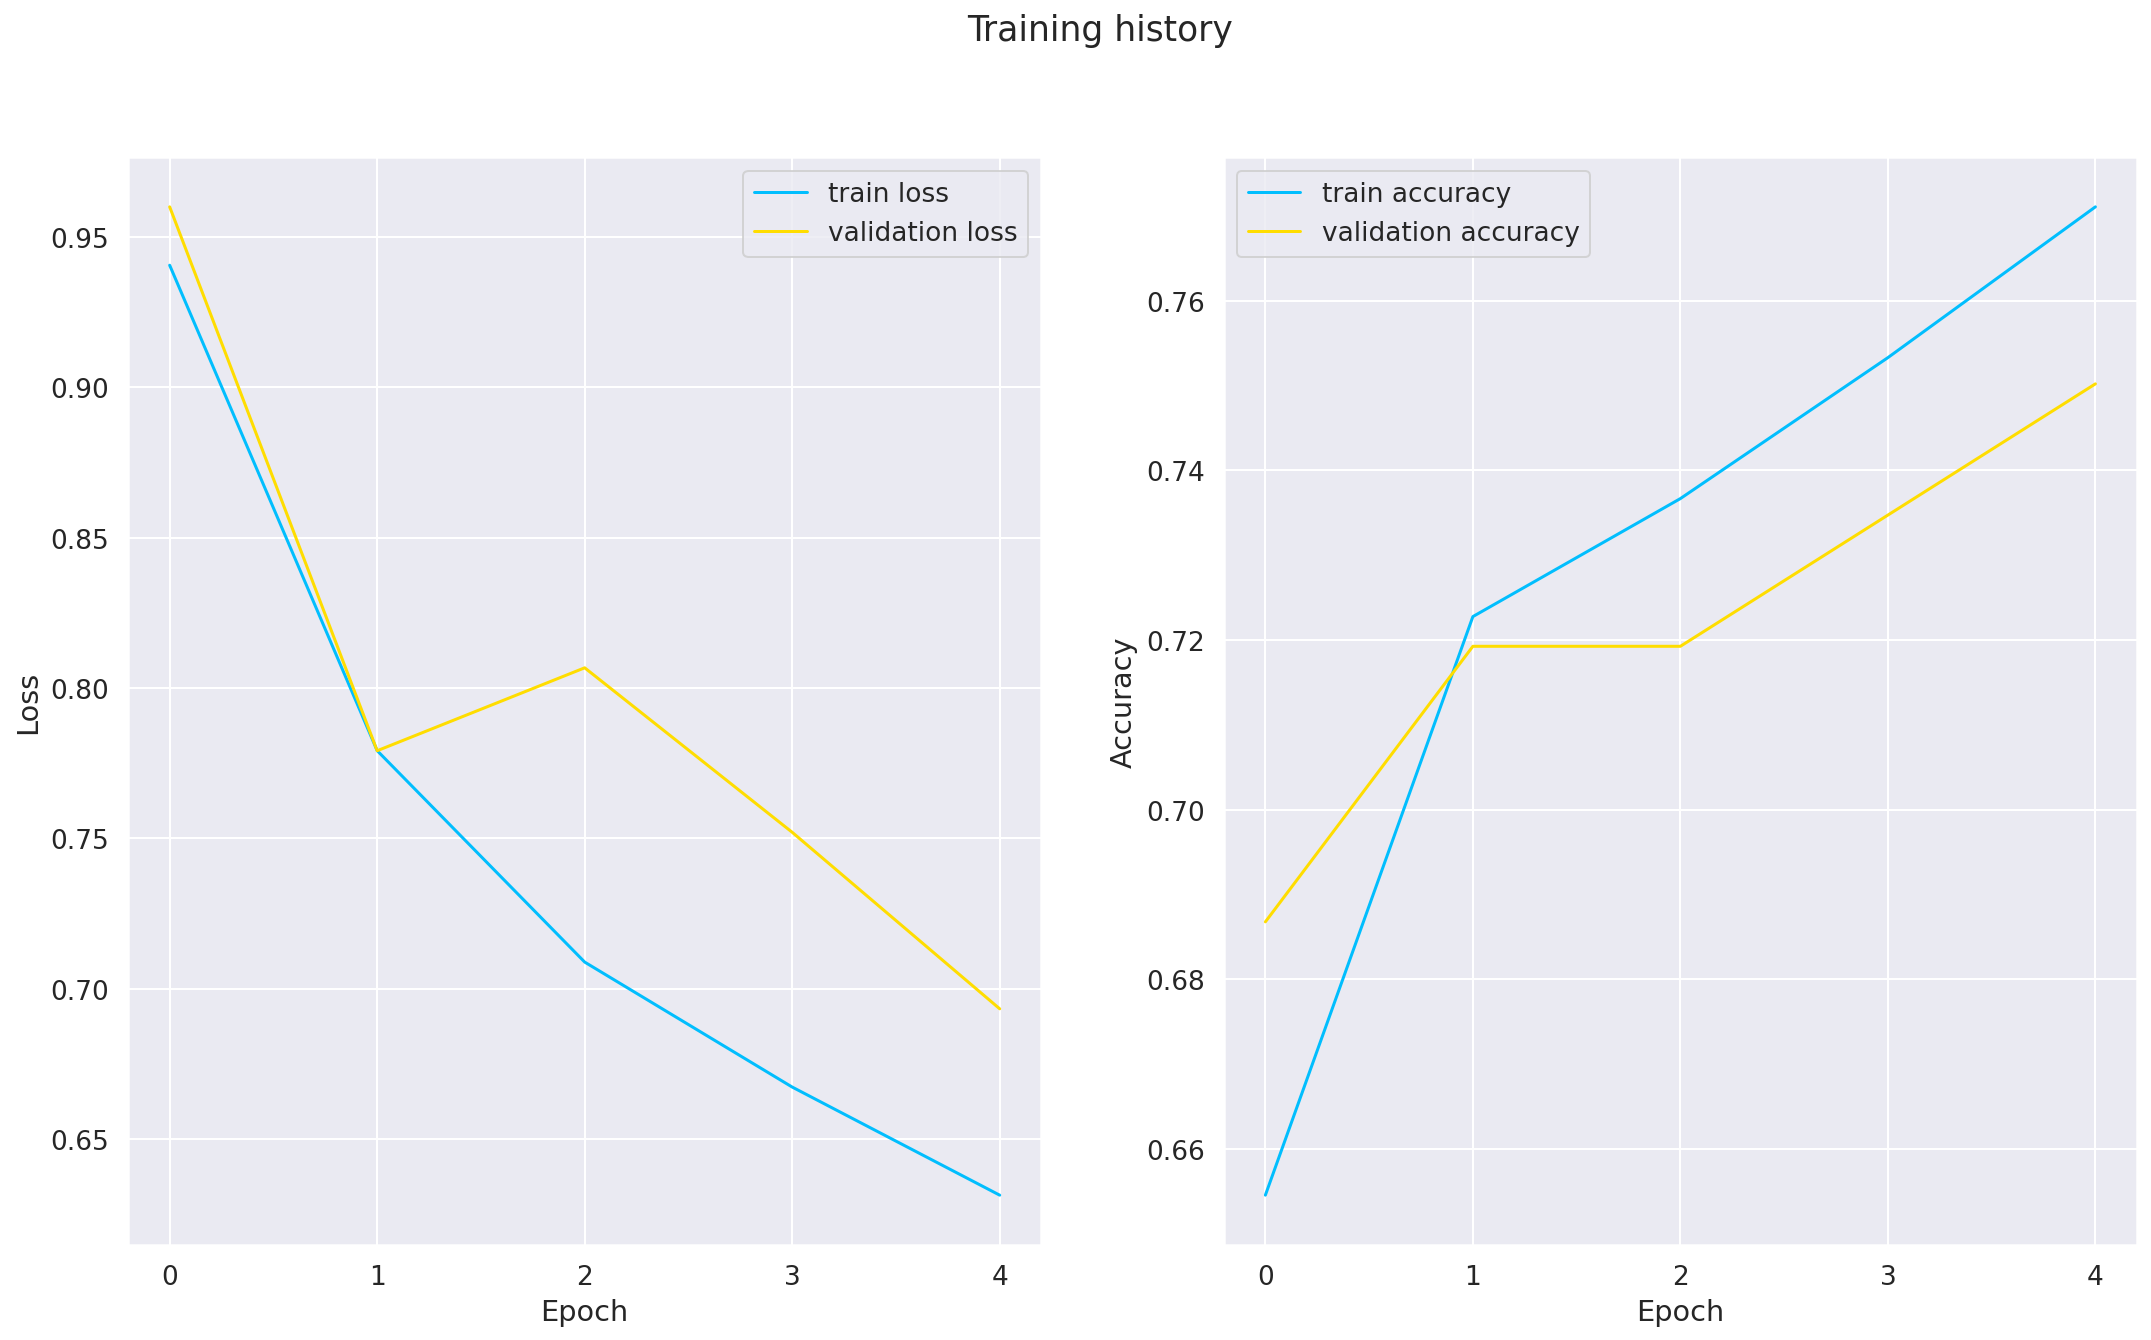

In [32]:
plot_training_history(history)

In [33]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []
    with torch.no_grad():
        for batch_idx , ( _ ,b_images ,b_labels ) in enumerate(data_loader):
            
            print(f' Processing batch {batch_idx + 1}/{len(data_loader)} ')    
          
            b_images = b_images.to(device)
            b_labels = b_labels.to(device)

            outputs = model(b_images)
            _, preds = torch.max(outputs, 1)
      
            predictions.extend(preds)
      
            real_values.extend(b_labels)
  
    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values

In [34]:
y_pred , y_true = get_predictions(model, train_loader)

 Processing batch 1/324 
 Processing batch 2/324 
 Processing batch 3/324 
 Processing batch 4/324 
 Processing batch 5/324 
 Processing batch 6/324 
 Processing batch 7/324 
 Processing batch 8/324 
 Processing batch 9/324 
 Processing batch 10/324 
 Processing batch 11/324 
 Processing batch 12/324 
 Processing batch 13/324 
 Processing batch 14/324 
 Processing batch 15/324 
 Processing batch 16/324 
 Processing batch 17/324 
 Processing batch 18/324 
 Processing batch 19/324 
 Processing batch 20/324 
 Processing batch 21/324 
 Processing batch 22/324 
 Processing batch 23/324 
 Processing batch 24/324 
 Processing batch 25/324 
 Processing batch 26/324 
 Processing batch 27/324 
 Processing batch 28/324 
 Processing batch 29/324 
 Processing batch 30/324 
 Processing batch 31/324 
 Processing batch 32/324 
 Processing batch 33/324 
 Processing batch 34/324 
 Processing batch 35/324 
 Processing batch 36/324 
 Processing batch 37/324 
 Processing batch 38/324 
 Processing batch 39/

In [35]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

      Airplane       0.90      0.38      0.53       425
        Candle       0.68      0.88      0.77       490
Christmas_Tree       0.88      0.85      0.86      1250
        Jacket       0.86      0.77      0.81       496
 Miscellaneous       0.78      0.84      0.81      2229
       Snowman       0.68      0.74      0.71       286

      accuracy                           0.80      5176
     macro avg       0.80      0.74      0.75      5176
  weighted avg       0.81      0.80      0.79      5176



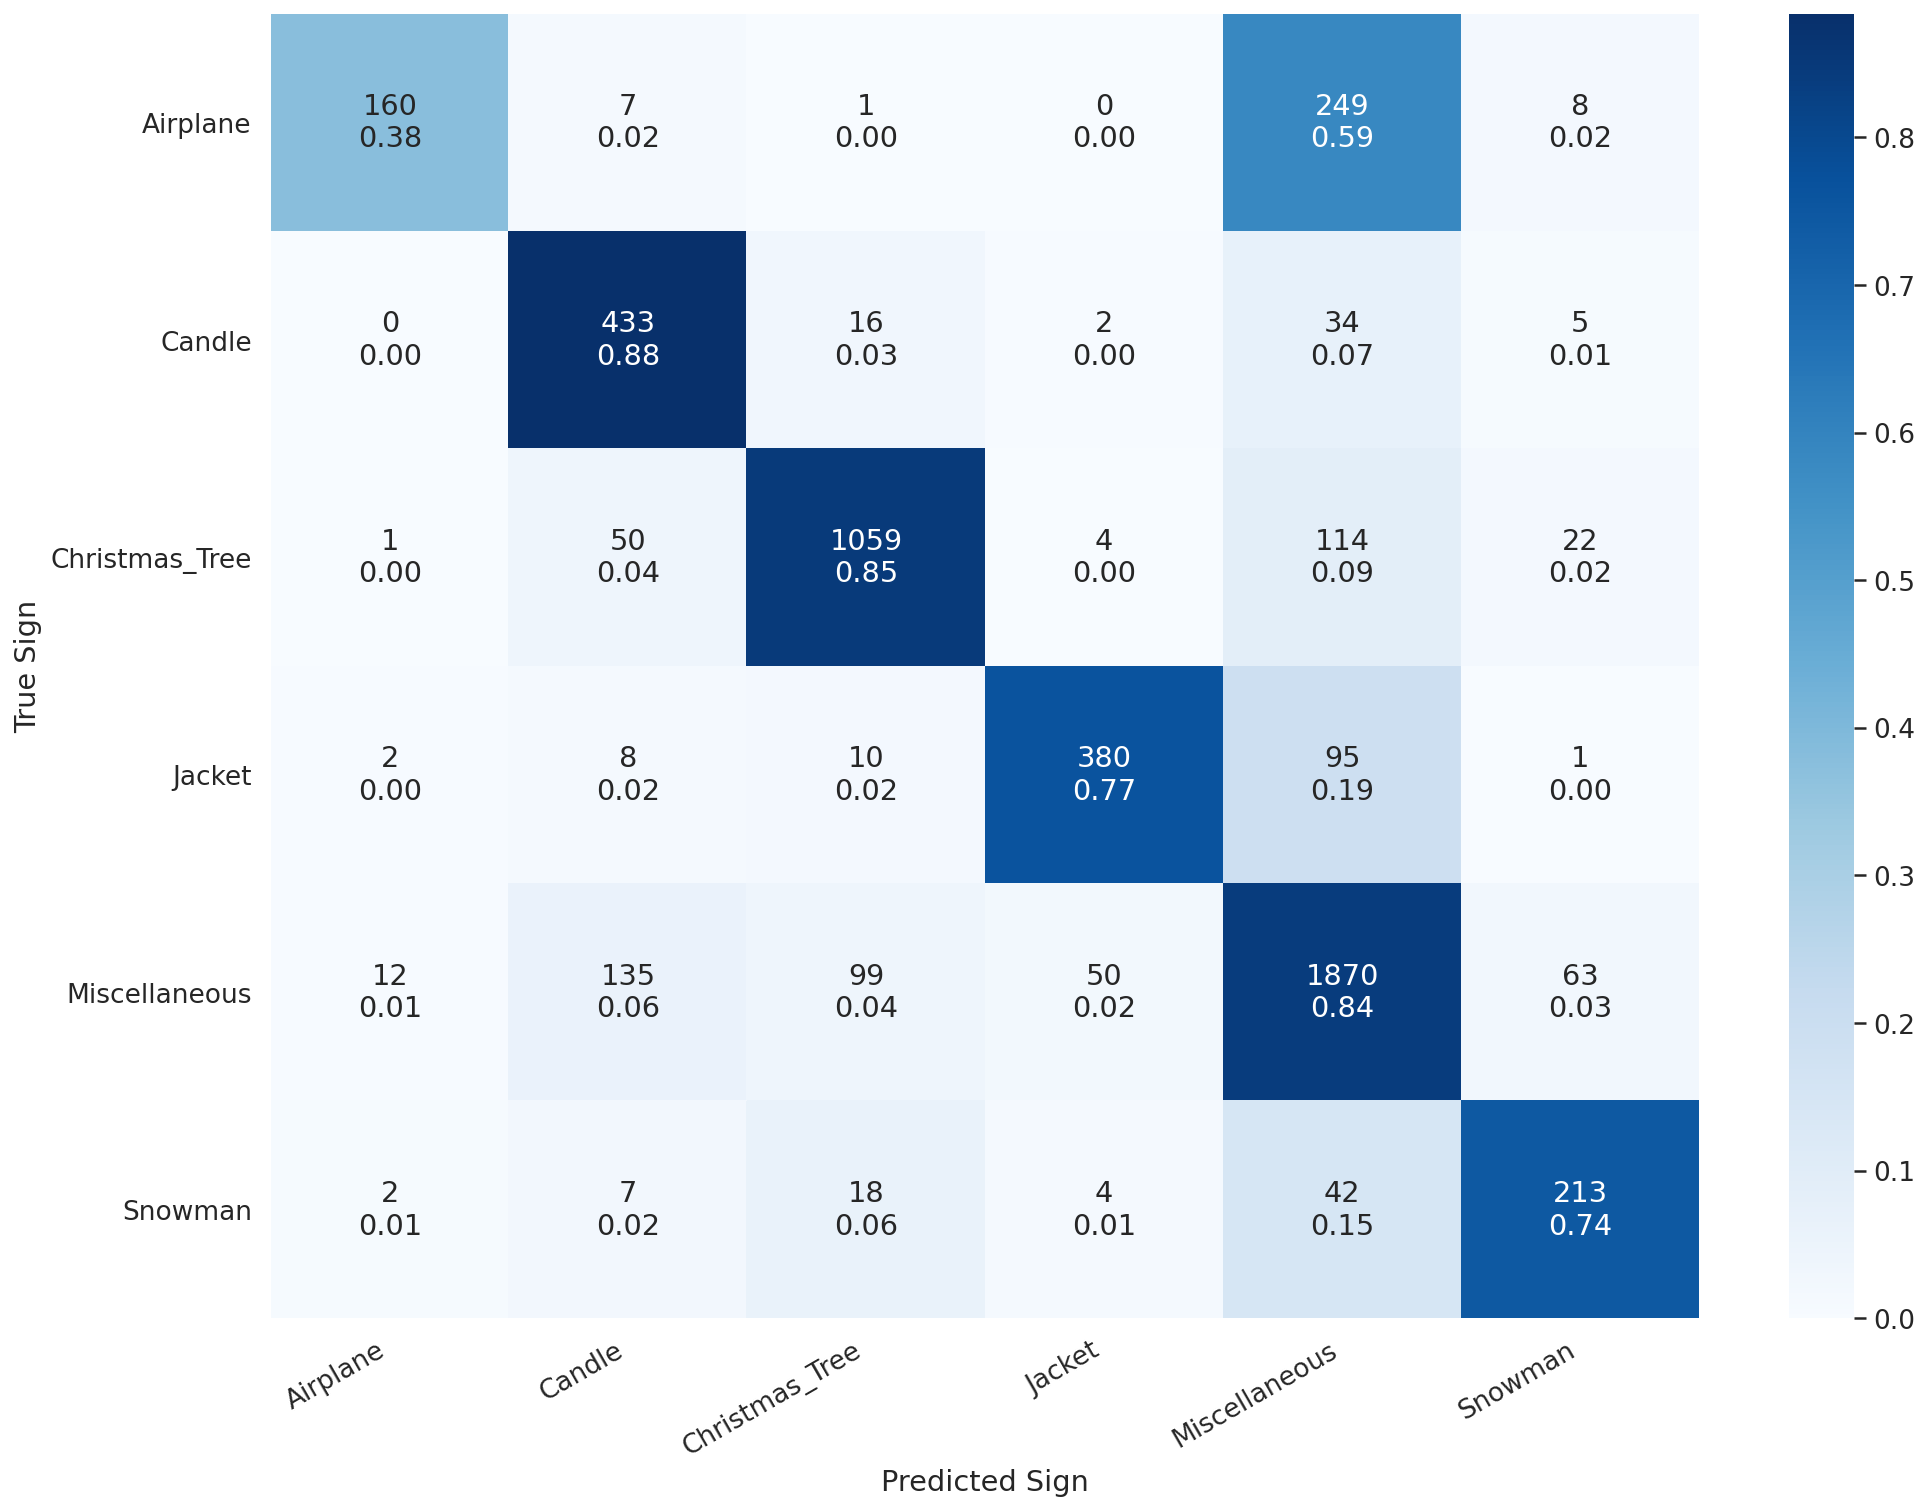

In [36]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [37]:
y_pred , y_true = get_predictions(model, validation_loader)

 Processing batch 1/81 
 Processing batch 2/81 
 Processing batch 3/81 
 Processing batch 4/81 
 Processing batch 5/81 
 Processing batch 6/81 
 Processing batch 7/81 
 Processing batch 8/81 
 Processing batch 9/81 
 Processing batch 10/81 
 Processing batch 11/81 
 Processing batch 12/81 
 Processing batch 13/81 
 Processing batch 14/81 
 Processing batch 15/81 
 Processing batch 16/81 
 Processing batch 17/81 
 Processing batch 18/81 
 Processing batch 19/81 
 Processing batch 20/81 
 Processing batch 21/81 
 Processing batch 22/81 
 Processing batch 23/81 
 Processing batch 24/81 
 Processing batch 25/81 
 Processing batch 26/81 
 Processing batch 27/81 
 Processing batch 28/81 
 Processing batch 29/81 
 Processing batch 30/81 
 Processing batch 31/81 
 Processing batch 32/81 
 Processing batch 33/81 
 Processing batch 34/81 
 Processing batch 35/81 
 Processing batch 36/81 
 Processing batch 37/81 
 Processing batch 38/81 
 Processing batch 39/81 
 Processing batch 40/81 
 Processi

In [38]:
print(classification_report(y_true, y_pred, target_names=class_names))

                precision    recall  f1-score   support

      Airplane       0.83      0.40      0.54       110
        Candle       0.62      0.83      0.71       103
Christmas_Tree       0.80      0.83      0.82       289
        Jacket       0.84      0.74      0.79       144
 Miscellaneous       0.75      0.77      0.76       572
       Snowman       0.57      0.73      0.64        75

      accuracy                           0.75      1293
     macro avg       0.74      0.71      0.71      1293
  weighted avg       0.76      0.75      0.74      1293



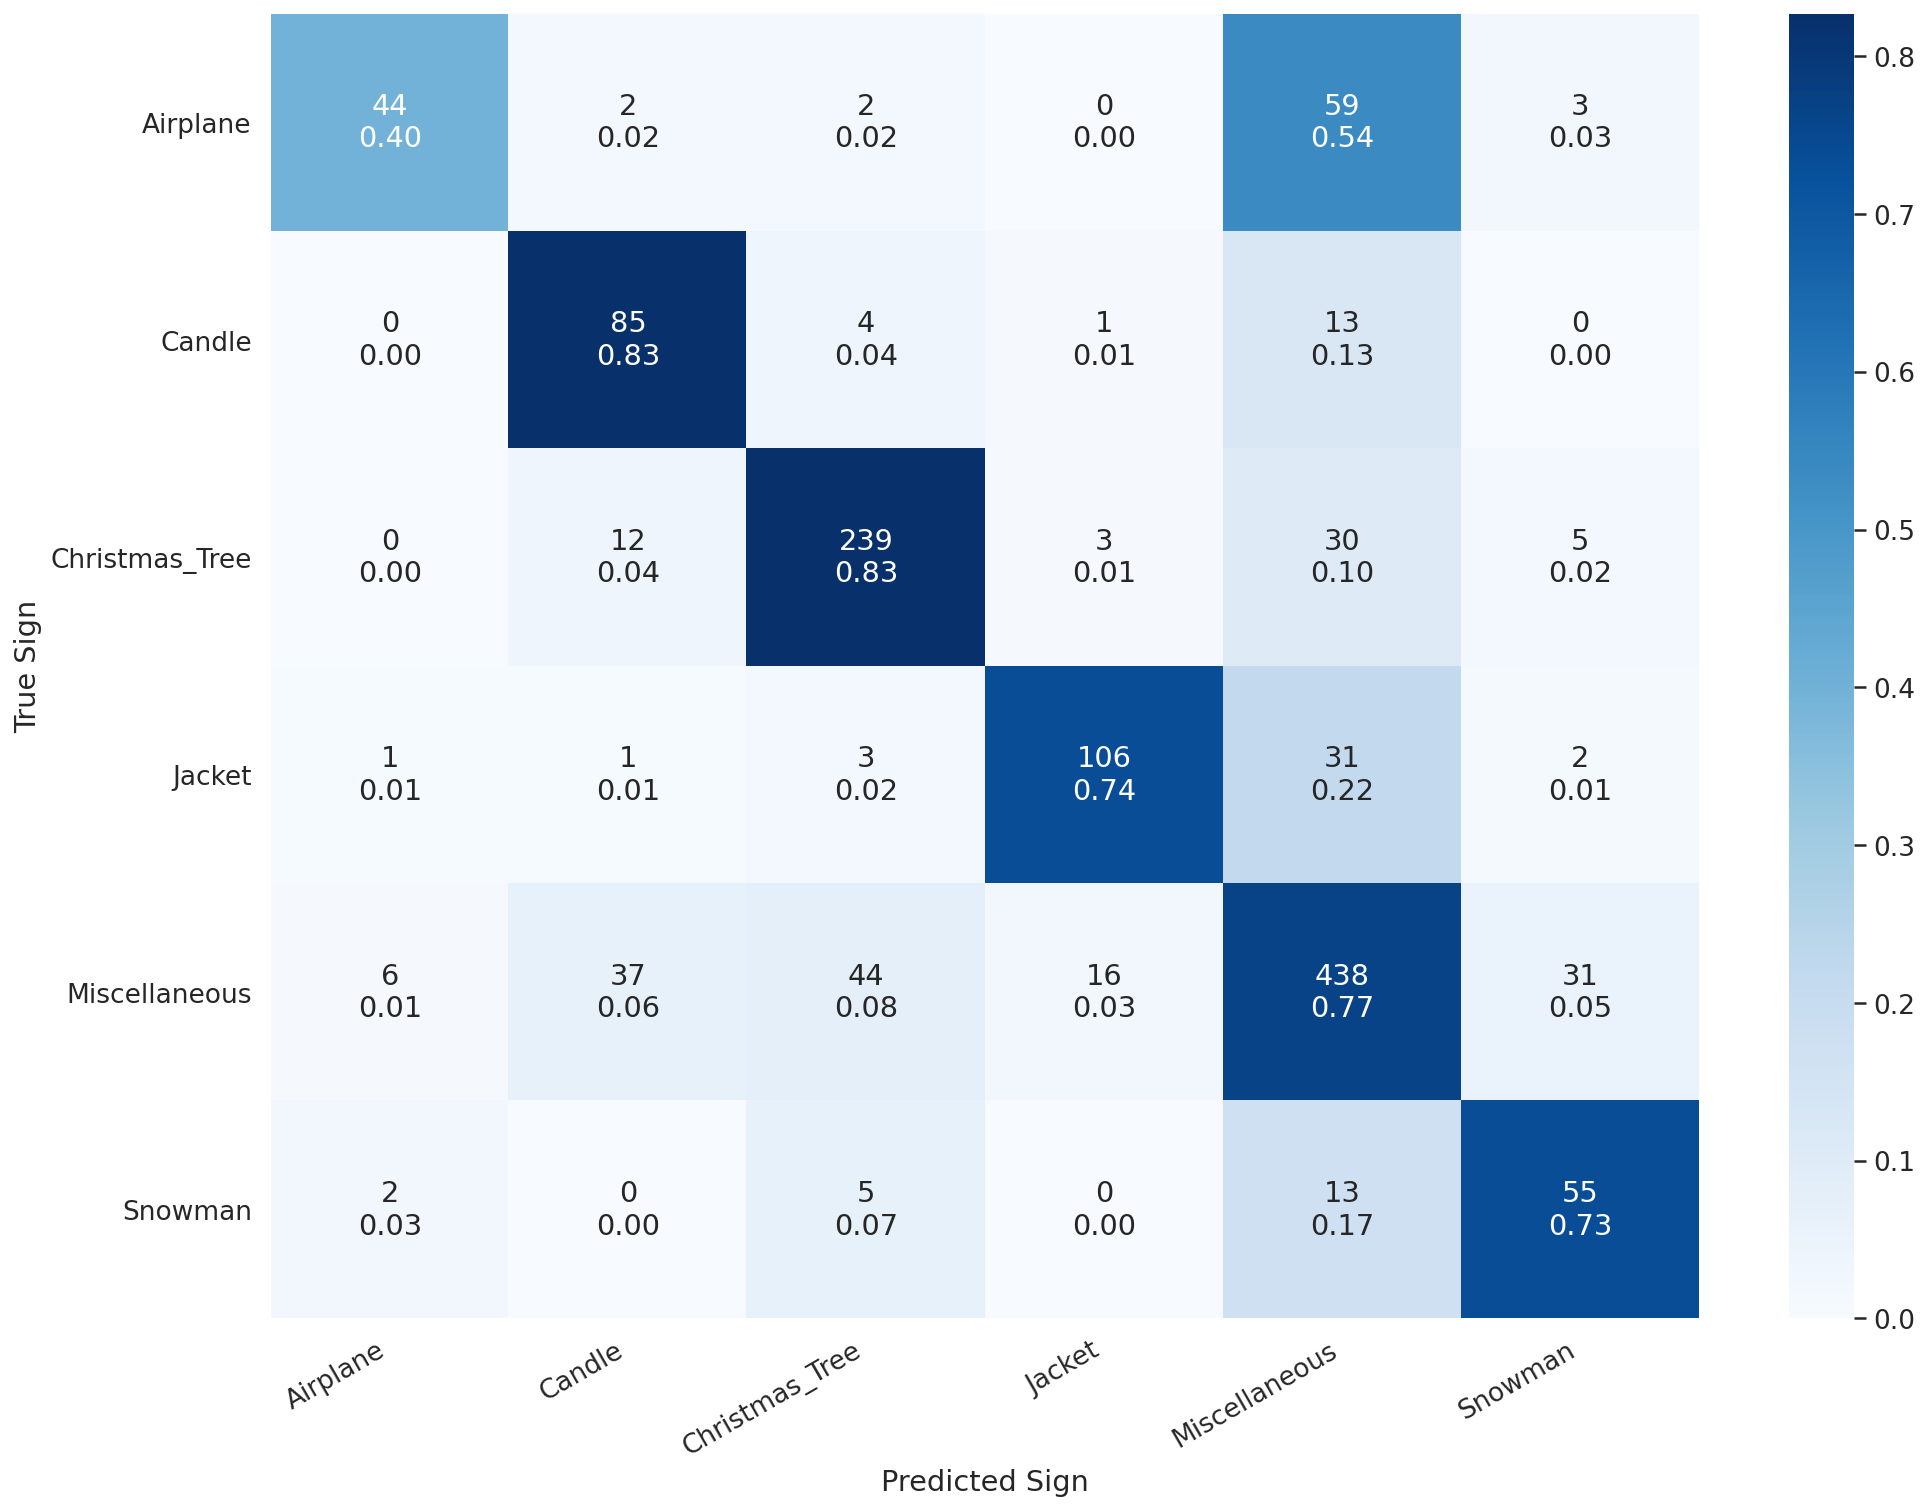

In [39]:
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)

In [40]:
def get_predictions_on_test(model, data_loader):
    model = model.eval()
    predictions = []
    imagenames = []
    with torch.no_grad():
        for batch_idx , (b_imagenames ,b_images) in enumerate(data_loader):
            
            print(f' Processing batch {batch_idx + 1}/{len(data_loader)} ')    
            
            b_images = b_images.to(device)
      
            outputs = model(b_images)
            _, preds = torch.max(outputs, 1)
    
            predictions.extend(preds)

            imagenames.extend(b_imagenames)

    predictions = torch.as_tensor(predictions).cpu()

    return imagenames , predictions

In [41]:
imagenames, predictions = get_predictions_on_test(model, test_loader)

 Processing batch 1/219 
 Processing batch 2/219 
 Processing batch 3/219 
 Processing batch 4/219 
 Processing batch 5/219 
 Processing batch 6/219 
 Processing batch 7/219 
 Processing batch 8/219 
 Processing batch 9/219 
 Processing batch 10/219 
 Processing batch 11/219 
 Processing batch 12/219 
 Processing batch 13/219 
 Processing batch 14/219 
 Processing batch 15/219 
 Processing batch 16/219 
 Processing batch 17/219 
 Processing batch 18/219 
 Processing batch 19/219 
 Processing batch 20/219 
 Processing batch 21/219 
 Processing batch 22/219 
 Processing batch 23/219 
 Processing batch 24/219 
 Processing batch 25/219 
 Processing batch 26/219 
 Processing batch 27/219 
 Processing batch 28/219 
 Processing batch 29/219 
 Processing batch 30/219 
 Processing batch 31/219 
 Processing batch 32/219 
 Processing batch 33/219 
 Processing batch 34/219 
 Processing batch 35/219 
 Processing batch 36/219 
 Processing batch 37/219 
 Processing batch 38/219 
 Processing batch 39/

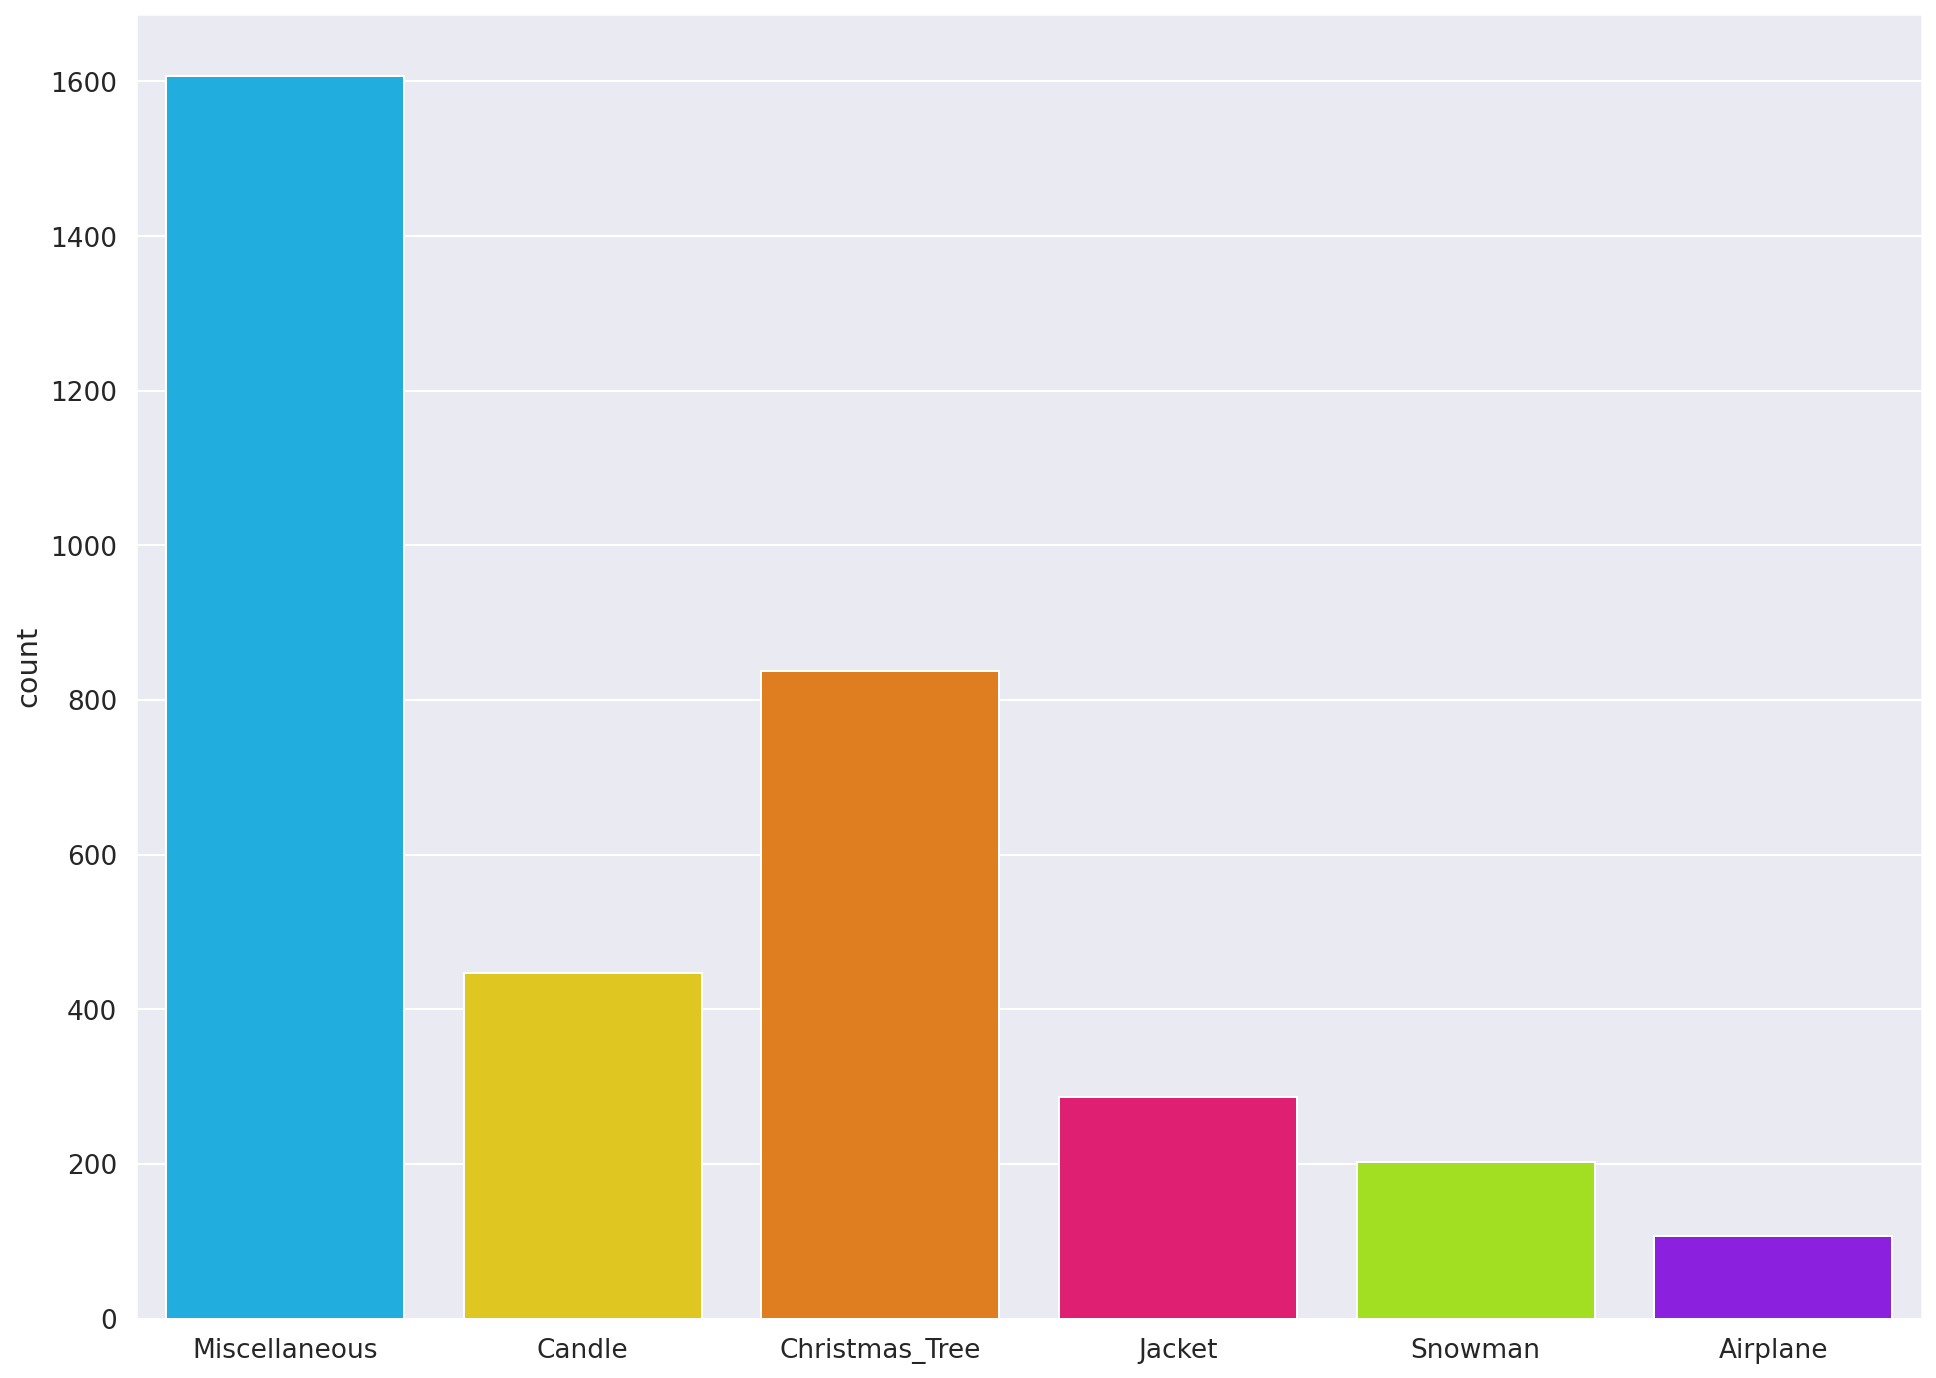

In [42]:
sns.countplot(x = le.inverse_transform(predictions))

In [43]:
df = pd.DataFrame(
    {
        'Image':imagenames,
        'Class':le.inverse_transform(predictions)
    }
)
df

,Image,Class
0,image6090.jpg,Miscellaneous
1,image5081.jpg,Miscellaneous
2,image9798.jpg,Candle
3,image2649.jpg,Miscellaneous
4,image995.jpg,Miscellaneous
...,...,...
3484,image5771.jpg,Snowman
3485,image7954.jpg,Miscellaneous
3486,image3154.jpg,Airplane
3487,image6014.jpg,Miscellaneous


In [44]:
df.to_csv(path_or_buf=os.path.join(curr_dir,'drive','MyDrive','HolidaySeason1','submission2.csv'),index = False )